# Importing packages

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Model class

In [3]:
class StepByStep(object):
    
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        self.train_loader = None
        self.valid_loader = None
        self.writer = None

        self.losses = []
        self.valid_losses = []
        self.total_epochs = 0

        self.train_step_fn = self._make_train_step_fn()
        self.valid_step_fn = self._make_valid_step_fn()

    def to(self, device):
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"{device} not available, sending to {self.device}")
            self.model.to(self.device)

    def set_loaders(self, train_loader, valid_loader=None):
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def set_tensorboard(self, name, folder='runs'):
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):

        def perform_train_step(x, y):

            self.model.train()

            y_hat = self.model(x)

            loss = self.loss_fn(y_hat, y)

            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

            return loss.item()
        
        return perform_train_step

    def _make_valid_step_fn(self):

        def perform_val_step(x, y):

            self.model.eval()

            y_hat = self.model(x)

            loss = self.loss_fn(y_hat, y)

            return loss.item()
        
        return perform_val_step
    
    def _get_minibatch_loss(self, validation=False):

        if validation:
            step_fn = self.valid_step_fn
            data_loader = self.valid_loader
        else:
            step_fn = self.train_step_fn
            data_loader = self.train_loader

        if data_loader is None:
            return None

        mini_batch_losses = []

        for x_batch, y_batch in data_loader:

            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_losses.append(step_fn(x_batch, y_batch))

        loss = np.mean(mini_batch_losses)
        
        return loss
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, epochs, seed=42):

        self.set_seed(seed)

        for epoch in range(epochs):

            self.total_epochs += 1

            loss = self._get_minibatch_loss(validation=False)
            self.losses.append(loss)

            with torch.no_grad():
                valid_loss = self._get_minibatch_loss(validation=True)
                self.valid_losses.append(valid_loss)

            if self.writer:
                scalars = {'training': loss}

                if valid_loss is not None:
                    scalars.update({'validation': valid_loss})

                self.writer.add_scalars(
                    main_tag='loss',
                    tag_scalar_dict=scalars,
                    global_step=epoch
                )

        if self.writer:
            self.writer.flush()

    def save_checkpoint(self, filename):
        checkpoint = {
            'epoch': self.total_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.valid_losses
        }

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        checkpoint = torch.load(filename)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.valid_losses = checkpoint['val_loss']

        self.model.train()

    def predict(self, x):
        self.model.eval()
        x_tensor = torch.as_tensor(x).float()
        y_hat_tensor = self.model(x_tensor.to(self.device))
        self.model.train()
        return y_hat_tensor.detach().cpu().numpy()
    
    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.valid_loader:
            plt.plot(self.valid_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig
    
    def add_graph(self):
        if self.train_loader and self.writer:
            x_dummy, y_dummy = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_dummy.to(self.device))

# Data generation

In [4]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

st_scaler = StandardScaler()

X_train = st_scaler.fit_transform(X_train)
X_val = st_scaler.transform(X_val)

# Dataloaders

In [5]:
torch.manual_seed(13)

X_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

X_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

# Model configuration

In [7]:
lr = 0.1

torch.manual_seed(42)

model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

optimizer = optim.SGD(model.parameters(), lr=lr)

loss_logits_fn = nn.BCEWithLogitsLoss(reduction='mean')

# Model training

In [8]:
sbs = StepByStep(model, loss_logits_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(100)

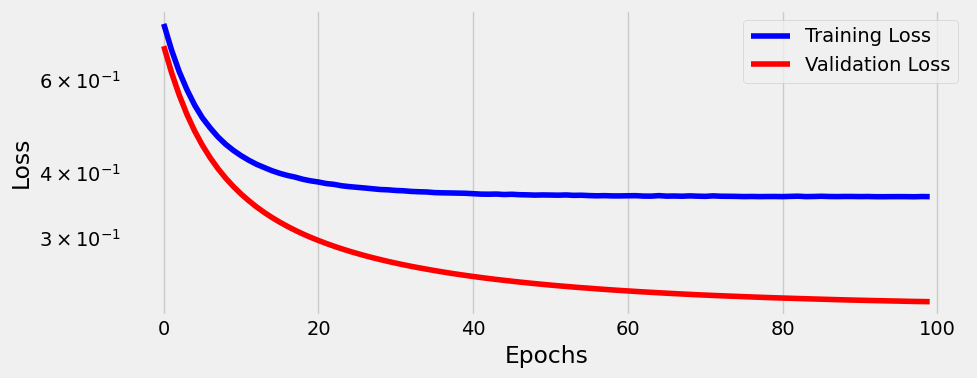

In [9]:
fig = sbs.plot_losses()

In [11]:
predictions = sbs.predict(X_train_tensor[:4])
print(predictions)

probabilities = torch.sigmoid(torch.as_tensor(predictions).float())
print(probabilities)

[[ 0.20345594]
 [ 2.9444456 ]
 [ 3.693318  ]
 [-1.2334074 ]]
tensor([[0.5507],
        [0.9500],
        [0.9757],
        [0.2256]])
